In [1]:
!pip install hypnettorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.9/456.9 kB 7.4 MB/s eta 0:00:00


In [4]:
import numpy as np
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_dir = '.'

Reading CIFAR-10 dataset ...
Elapsed time to read dataset: 4.644131 sec


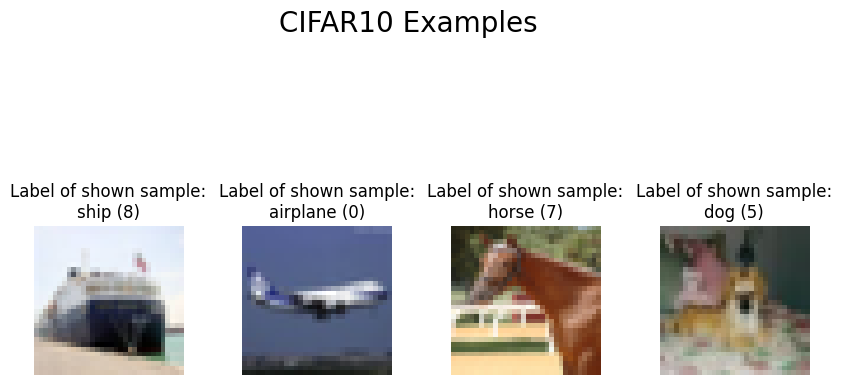

In [6]:
from hypnettorch.data import CIFAR10Data
cifar10 = CIFAR10Data(data_dir, use_one_hot=True, validation_size=0)
cifar_inps, cifar_trgts = cifar10.next_train_batch(4)
cifar10.plot_samples('CIFAR10 Examples', cifar_inps, outputs=cifar_trgts)

In [11]:
#
#set the number of input features to 1, 
##specified 3 RNN layers with 10, 20, and 30 hidden units respectively, 
#and 2 fully-connected layers with 50 and 1 hidden units 

from hypnettorch.mnets.simple_rnn import SimpleRNN

# Define the number of input features
n_in = 1

# Define the number of hidden units for each RNN layer
rnn_layers = (10, 20, 30)

# Define the number of hidden units for each fully-connected layer
fc_layers = (50, 1)

# Instantiate the SimpleRNN class with the desired parameters
mnet = SimpleRNN(n_in=n_in, rnn_layers=rnn_layers, fc_layers=fc_layers, use_lstm=True)

# Move the model to the desired device
mnet.to(device)


Creating a simple RNN with 10921 weights.


SimpleRNN(
  (_a_fun): Tanh()
  (_weights): ParameterList(
      (0): Parameter containing: [torch.float32 of size 40x1]
      (1): Parameter containing: [torch.float32 of size 40]
      (2): Parameter containing: [torch.float32 of size 40x10]
      (3): Parameter containing: [torch.float32 of size 40]
      (4): Parameter containing: [torch.float32 of size 80x10]
      (5): Parameter containing: [torch.float32 of size 80]
      (6): Parameter containing: [torch.float32 of size 80x20]
      (7): Parameter containing: [torch.float32 of size 80]
      (8): Parameter containing: [torch.float32 of size 120x20]
      (9): Parameter containing: [torch.float32 of size 120]
      (10): Parameter containing: [torch.float32 of size 120x30]
      (11): Parameter containing: [torch.float32 of size 120]
      (12): Parameter containing: [torch.float32 of size 50x30]
      (13): Parameter containing: [torch.float32 of size 50]
      (14): Parameter containing: [torch.float32 of size 1x50]
      (15)

In [12]:
from hypnettorch.hnets import HMLP
hnet = HMLP(mnet.param_shapes, uncond_in_size=0, cond_in_size=8,
            layers=[100, 100], num_cond_embs=2).to(device)

print()
print('The randomly initialized input embeddings are:\n', 
      hnet.conditional_params)

# To produce main network weights for condition `0`, we can either pass
# the corresponding condition ID, or the corresponding (internally maintained)
# embedding to the `forward` of the hypernetwork.
W0 = hnet.forward(cond_id=0)
W0_tmp = hnet.forward(cond_input=hnet.conditional_params[0].view(1, -1))
assert np.all([torch.equal(W0[i], W0_tmp[i]) for i in range(len(W0))])

# Hypernetworks also allow batch processing.
W_batch = hnet.forward(cond_id=[0, 0])
assert np.all([torch.equal(W_batch[0][i], W_batch[1][i]) \
               for i in range(len(W0))])

Created MLP Hypernet.
Hypernetwork with 1114037 weights and 10921 outputs (compression ratio: 102.01).
The network consists of 1114021 unconditional weights (1114021 internally maintained) and 16 conditional weights (16 internally maintained).

The randomly initialized input embeddings are:
 [Parameter containing:
tensor([ 0.8733,  0.5389,  0.2481, -1.2093,  0.0781, -0.2150, -0.3982,  0.9141],
       requires_grad=True), Parameter containing:
tensor([-0.2393, -0.2898,  1.8086, -0.5480,  1.0478, -1.3881, -0.7224,  0.9372],
       requires_grad=True)]


In [13]:
hnet.apply_hyperfan_init(mnet=mnet)